# 1. Runge-Kutta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [5]:
def derivs_orbit(t, x):
    rr = (x[0]**2 + x[1]**2)**0.5
    vxdot = -x[0]/rr**3
    vydot = -x[1]/rr**3
    xdot = x[2]
    ydot = x[3]
    return np.array((xdot,ydot,vxdot,vydot))

In [6]:
def rk4(nsteps, dt, x0, derivs):
    x = np.zeros((nsteps,len(x0)))
    x[0] = x0
    for i in range(1,nsteps):    
        f = derivs((i-1)*dt, x[i-1])
        f1 = derivs((i-1)*dt + dt/2, x[i-1] + f*dt/2)
        f2 = derivs((i-1)*dt + dt/2, x[i-1] + f1*dt/2)
        f3 = derivs(i*dt, x[i-1] + f2*dt)
        x[i] = x[i-1] + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x

Equal size steps: Minimum no. steps = 4030, err = 9.95367e-07


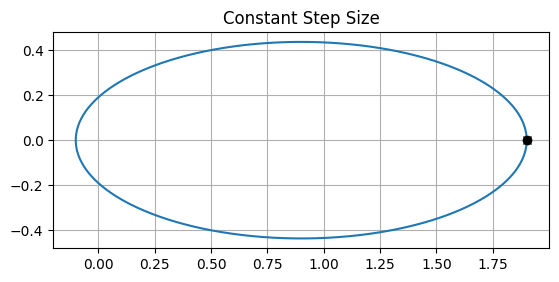

In [15]:
steps_arr = np.linspace(10,1e4,1000, dtype=int)
for nsteps in steps_arr:
    e = 0.9
    r = 1 + e
    dt = 2 * np.pi / (nsteps-1)
    t = np.arange(nsteps)*dt
    x_start = np.array((r,0,0,np.sqrt((2/r) - 1)))
    x4 = rk4(nsteps, dt, x_start, derivs_orbit)

    if np.abs(x4[-1,1]) <= 1e-6:
        print("Equal size steps: Minimum no. steps = %d, err = %lg" % (nsteps, x4[-1,1]))
        break
    
plt.gca().set_aspect('equal')
plt.plot(x4[:,0], x4[:,1])

plt.plot(x4[0,0],x4[0,1],'ko')
plt.plot(x4[-1,0],x4[-1,1],'kx')
plt.title('Constant Step Size', fontsize=18)
plt.grid()
plt.show()

In [9]:
# We need a different rk4 function since we don't want to use the same step size each time it is called now

def rk4_adapt(dt, x, derivs):
    f = derivs(dt, x)
    f1 = derivs(dt + dt/2, x + f*dt/2)
    f2 = derivs(dt + dt/2, x + f1*dt/2)
    f3 = derivs(dt, x + f2*dt)
    x_step = x + dt*(f + 2*f1 + 2*f2 + f3)/6
    return x_step

### Chat GPT helped me write the integrate function:

Adaptive size steps: Minimum no. steps = 73


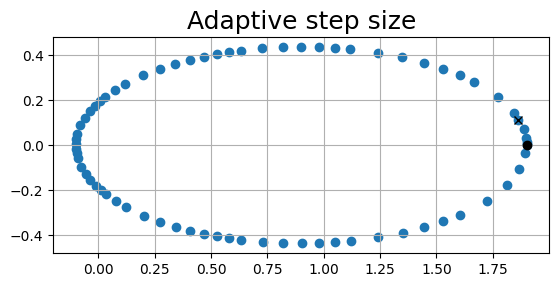

In [18]:
def integrate(tol):
    t = 0
    e = 0.9
    x = np.array([1.0 + e, 0, 0, np.sqrt((2 / (1 + e) - 1))])  
    h = 0.01  
    t_vals = []
    x_vals = []
    
    while t < 2 * np.pi:
        # Take a single RK4 step
        x_full = rk4_adapt(h, x, derivs_orbit)
        
        # Take two half-sized steps
        x_half = rk4_adapt(h / 2, x, derivs_orbit)
        x_half = rk4_adapt(h / 2, x_half, derivs_orbit)

        # Calculate error
        error = np.min(np.abs(x_half - x_full))
        
        if error < tol:
            t += h
            x = x_full
            t_vals.append(t)
            x_vals.append(x)
            # Increase the step size by a factor of 2
            h *= 2
        else:
            # Decrease the step size by a factor of 2
            h /= 2

    return np.array(t_vals), np.array(x_vals)

# Define the desired tolerance
tol = 1e-6

# Integrate the eccentric orbit
t_vals, x_vals = integrate(tol)
x_vals = np.array(x_vals)

print("Adaptive size steps: Minimum no. steps = %d" % (len(x_vals)))


plt.gca().set_aspect('equal')
plt.scatter(x_vals[:, 0], x_vals[:, 1])
plt.plot(x_vals[0,0],x_vals[0,1],'ko')
plt.plot(x_vals[-1,0],x_vals[-1,1],'kx')
plt.title('Adaptive step size', fontsize = 18)
plt.grid()
plt.show()




# 2. Method of Lines

I took a numerical methods class in undegrad, which included nearly the exact same example problem. I am drawing heavily from that class material and its website: 

https://kyleniemeyer.github.io/ME373-book/content/pdes/parabolic.html

To avoid solutions that blow up, I use an implicit method to represent the left hand side of equation 13. The temperatures at a times $t_j$ and positions $x_i$.



$$\frac{dT_i}{dt} = \frac{T_{i+1} - 2T_i + t_{i-1}}{\Delta x^2}$$
$$\frac{T_i^{j+1} - T_i^j}{\Delta t} = \frac{T_{i+1} - 2T_i + T_{i-1}}{\Delta x^2}$$

The because I use Backward Euler as my implicit scheme, the right hand side is evaluated at time $t_{j+1}$.

$$\frac{T_i^{j+1} - T_i^j}{\Delta t} = \frac{T_{i+1}^{j+1} - 2T_i^{j+1} + T_{i-1}^{j+1}}{\Delta x^2}$$

Isolating $T_i^j$, the temperature at current time and position:

$$   $$



$$T_i^j = -\Delta t\frac{T_{i+1}^{j+1} - 2T_i^{j+1} + T_{i-1}^{j+1}}{\Delta x^2} + T_i^{j+1}$$

$$$$


$$T_i^j = (-\frac{\Delta t}{\Delta x^2})T_{i+1}^{j+1} + (-\frac{\Delta t}{\Delta x^2})T_{i-1}^{j+1} + (1 + 2\frac{\Delta t}{\Delta x^2})T_i^{j+1}$$

$$$$

Let's rename $\frac{\Delta t}{\Delta x^2}$ as some constant Z:


$$T_i^j = (-Z)T_{i+1}^{j+1} + (-Z)T_{i-1}^{j+1} + (1 + 2Z)T_i^{j+1}$$

Because this is implict in time, we hav to solve simultaneously. We can use linear algebra to solve the systems of equations:

$$AT^{j+1} = T^j = b$$

In [27]:
dx = 0.05
dt = 0.05
Z = dt / (dx**2)

x_vals = np.arange(0, 1.001, dx)
times = np.arange(0, 1.0001, dt)

temps = np.zeros((len(times), len(x_vals)))

# Initial Conditions
temps[0,:] = 1
temps[0,-1] = 0

for j, t in enumerate(times[:-1]):
    A = np.zeros((len(x_vals), len(x_vals)))
    b = np.zeros(len(x_vals))
    for idx, x in enumerate(x_vals):
        if idx == 0:
            # Boundary condition at x = 0
            A[idx,idx] = 1 # No coefficient
            b[idx] = 1
        elif idx == len(x_vals) - 1:
          # Boundary condition at x = 1
            A[idx,idx] = 1 # No coefficient
            b[idx] = 0
        else:
            A[idx,idx-1] = -Z
            A[idx,idx] = 2*Z + 1
            A[idx,idx+1] = -Z
            b[idx] = temps[j,idx]
    temps[j+1,:] = np.linalg.solve(A, b)



In [28]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.grid()
line, = ax.plot([], [], lw=2)
time_template = 'time = %.1f s'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.1])
ax.set_xlabel('Distance')
ax.set_ylabel('Temperature')

def animate(k):
    line.set_data((x_vals, temps[k,:]))
    time_text.set_text(time_template % (k*dt))
    return line, time_text

ani = animation.FuncAnimation(fig, animate, len(times), interval=10000)

writer = animation.PillowWriter(fps=1)  
ani.save('parabolic_implicit_animated.gif', writer=writer)  

plt.close()

The animation seems to make sense, since once the system settles to thermal equilbrium, it should follow Fourier's Law of Conduction in the 1-D case:

$$q \propto \frac{dT}{dx}$$

At thermal equilbrium the heat flow is constant because it is driven by the constant temperature on either boundary, giving a constant slope for the thermal profile.